In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import importlib
from torch.utils.data import DataLoader
import os
!pip install matplotlib

from config import Blip2Config
from dataset import Blip2Dataset
from tokenizer import FlanT5Tokenizer, BertTokenizer

Defaulting to user installation because normal site-packages is not writeable


In [2]:
print(torch.cuda.is_available())

import config, dataset, tokenizer
importlib.reload(config)
importlib.reload(dataset)
importlib.reload(tokenizer)

from config import Blip2Config
from dataset import Blip2Dataset
from tokenizer import FlanT5Tokenizer, BertTokenizer

True


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
t5_model_name = "google/flan-t5-small"
bert_autotokenizer =  AutoTokenizer.from_pretrained("bert-base-uncased") 
t5_autotokenizer = AutoTokenizer.from_pretrained(t5_model_name)

config = Blip2Config()

flan_t5_tokenizer = FlanT5Tokenizer(config, t5_autotokenizer)
bert_tokenizer = BertTokenizer(config, bert_autotokenizer)
config.bert_vocab_size = bert_tokenizer.n_vocab
config.t5_vocab_size = flan_t5_tokenizer.n_vocab

stage1_train_dataset = Blip2Dataset(config, split="train", tokenizer=bert_tokenizer.tokenize_text, type="bert")
stage1_train_dataloader = DataLoader(stage1_train_dataset, batch_size=config.batch_size, shuffle=True)

stage2_train_dataset = Blip2Dataset(config, split="train", tokenizer=flan_t5_tokenizer.tokenize_text, type="flan_t5")
stage2_train_dataloader = DataLoader(stage2_train_dataset, batch_size=config.batch_size, shuffle=False)

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping non-image file: image
Skipping non-image file: image


In [20]:
import copy
import timm
from transformers import BertConfig, BertModel

class BertMLPBlock(nn.Module):
    def __init__(self, intermediate, output):
        super().__init__()
        self.intermediate = intermediate
        self.output = output

    def forward(self, x):
        intermediate_output = self.intermediate(x)
        return self.output(intermediate_output, x)
    

class BertEncoderBlock(nn.Module):
    def __init__(self, bert_layer, bert_config, is_cross_attn=False):
        super().__init__()
        self.bert_config = bert_config
        self.is_cross_attn = is_cross_attn

        d = bert_config.hidden_size
        h = bert_config.num_attention_heads
        self.self_attn = nn.MultiheadAttention(d, h, batch_first=True)
        self.self_ln = nn.LayerNorm(d)

        self.mlp_img_transformer = BertMLPBlock(bert_layer.intermediate, bert_layer.output)
        self.mlp_text_transformer = BertMLPBlock(
                    copy.deepcopy(bert_layer.intermediate), 
                    copy.deepcopy(bert_layer.output)
                    )
        if is_cross_attn:
            self.cross_attn = nn.MultiheadAttention(embed_dim=self.bert_config.hidden_size, 
                                                    num_heads=self.bert_config.num_attention_heads, 
                                                    batch_first=True)
            self.cross_layer_norm = nn.LayerNorm(self.bert_config.hidden_size)
        
    def forward(self, query_embds, img_embds, text_embds, attn_mask):
        _, Qs, _ = query_embds.shape
        _, Ts, _ = text_embds.shape

        combined_embds = torch.concat((query_embds, text_embds), dim=1) # B, Qs + Ts, D

        attn_out, _ = self.self_attn(
            combined_embds, combined_embds, combined_embds,
            attn_mask=attn_mask,         # (L, L), broadcast over batch & heads
            key_padding_mask=None     # (B, L) bool, True=mask (optional)
        )
        combined_embds = self.self_ln(combined_embds+ attn_out)

        query_embds = combined_embds[:, :Qs]
        text_embds= combined_embds[:, Qs:]
        
        if self.is_cross_attn:
            hidden_states = self.cross_attn(query_embds, img_embds, img_embds)[0]
            query_embds = self.cross_layer_norm(query_embds + hidden_states)

        query_embds = self.mlp_img_transformer(query_embds)
        text_embds = self.mlp_text_transformer(text_embds)
        return query_embds, text_embds


class QTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.bert_cfg  = BertConfig.from_pretrained("bert-base-uncased")
        self.bert_model = BertModel.from_pretrained("bert-base-uncased", config = self.bert_cfg)
        print("num of bert layers ",self.bert_model.encoder.layer)
        self.encoder = nn.ModuleList()
        for i, bert_layer in enumerate(self.bert_model.encoder.layer):
            if(i>6):
                break
            self.encoder.append(BertEncoderBlock(bert_layer, self.bert_cfg, i % 2 == 0))
        
        qs = config.num_queries
        ts = config.context_length
        combined_seq_len = qs + ts

        ####  STAGE 1: ITC, ITM, ITG Loss Masks ####
        # ITC Loss Mask
        itc_attn_mask = torch.zeros((combined_seq_len, combined_seq_len))
        itc_attn_mask[:qs, :qs] = 1
        itc_attn_mask[qs:, qs:] = 1
        

        # ITM Loss Mask
        itm_attn_mask = torch.ones((combined_seq_len, combined_seq_len))

        # ITG Loss Mask
        itg_attn_mask = torch.ones((combined_seq_len, combined_seq_len))
        itg_attn_mask[:qs, qs:] = 0
        itg_attn_mask[qs:, qs:] = torch.tril(itg_attn_mask[qs:, qs:], diagonal=0)


        self.register_buffer("itc_attn_mask", itc_attn_mask)
        self.register_buffer("itm_attn_mask", itm_attn_mask)
        self.register_buffer("itg_attn_mask", itg_attn_mask)

        ####  STAGE 2: ####
        # ITC Loss Mask will be same as stage 1 and reused for stage 2

    def forward(self, query_embds, img_embds, cls_text_embds, dec_text_embds, stage):

        itc_query_embds = query_embds.clone()
        itm_query_embds = query_embds.clone()
        itg_query_embds = query_embds.clone()

        itc_text_embds = cls_text_embds.clone()
        itm_text_embds = cls_text_embds.clone()
        itg_text_embds = dec_text_embds.clone()

        device = query_embds.device
        dtype  = query_embds.dtype

        # Convert base masks to additive for this device/dtype
        itc_add = to_additive_mask(self.itc_attn_mask, device=device, dtype=dtype)
        itm_add = to_additive_mask(self.itm_attn_mask, device=device, dtype=dtype)
        itg_add = to_additive_mask(self.itg_attn_mask, device=device, dtype=dtype)


        for encoder in self.encoder:
            itc_query_embds, itc_text_embds = encoder(itc_query_embds, img_embds, itc_text_embds, itc_add)
            if stage == 1:
                itm_query_embds, itm_text_embds = encoder(itm_query_embds, img_embds, itm_text_embds, itm_add)
                itg_query_embds, itg_text_embds = encoder(itg_query_embds, img_embds, itg_text_embds, itg_add)
        return itc_query_embds, itc_text_embds, itm_query_embds, itm_text_embds, itg_query_embds, itg_text_embds
    

class QFormer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.q_transformer = QTransformer(config)
        self.learned_query = nn.Parameter(torch.randn(config.num_queries, config.embedding_dim))
        self.output_embedding  = nn.Embedding(config.bert_vocab_size, config.embedding_dim)
        self.position_embedding = nn.Embedding(config.context_length, config.embedding_dim)

        position_ids = torch.arange(self.config.context_length).unsqueeze(0)
        self.register_buffer("position_ids", position_ids)

    def forward(self, image_embedding: torch.tensor, cls_tokens: torch.tensor, dec_tokens: torch.tensor, stage:int):
        B, S, E = image_embedding.shape
        learned_query = self.learned_query.unsqueeze(0).expand(B, -1, -1)

        cls_text_embeddings = self.output_embedding(cls_tokens) #(S,768)
        cls_text_embeddings = cls_text_embeddings + self.position_embedding(self.position_ids.expand(B, -1))
        dec_text_embeddings = self.output_embedding(dec_tokens) #(S,768)
        dec_text_embeddings = dec_text_embeddings + self.position_embedding(self.position_ids.expand(B, -1))

        itc_query_embds, itc_text_embds, itm_query_embds, itm_text_embds, itg_query_embds, itg_text_embds = self.q_transformer(
            learned_query, image_embedding, cls_text_embeddings, dec_text_embeddings, stage)

        if itg_text_embds is not None:
            itg_logits = itg_text_embds @ self.output_embedding.weight.T # (S,Vocab_size)
        else:
            itg_logits = None

        return itc_query_embds, itc_text_embds, itm_query_embds, itm_text_embds, itg_logits


class FlanT5Model(nn.Module):
    def __init__(self):
        super(FlanT5Model, self).__init__()
        self.lm_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
        for param in self.lm_model.parameters():
            param.requires_grad = False

    def forward(self, query_embedding, input_token, label, enc_mask):
        #query_embd : (B,32,512)
        # input_token : (B,L)
        B, Q, d = query_embedding.shape
        device = query_embedding.device
        with torch.no_grad():
            input_embd = self.lm_model.encoder.embed_tokens(input_token)  #(B,L,512)

        encoder_input = torch.concat((query_embedding, input_embd) , dim = 1).contiguous()

        prefix_mask = torch.ones((B, Q ), dtype= enc_mask.dtype, device=device)
        attention_mask = torch.concat((prefix_mask, enc_mask) , dim=1).contiguous()  # [B, 32+L]
        label = label.contiguous()  # [B, L]
        out = self.lm_model(inputs_embeds=encoder_input,
                                attention_mask=attention_mask,
                                labels=label,
                                return_dict=True)
        return out
    

    def predict(self, query_embedding, input_token, enc_mask):
        B, Q, d = query_embedding.shape
        device = query_embedding.device
        with torch.no_grad():
            input_embd = self.lm_model.encoder.embed_tokens(input_token)  #(B,L,512)

        encoder_input = torch.concat((query_embedding, input_embd) , dim = 1)

        prefix_mask = torch.ones((B, Q ), dtype= enc_mask.dtype, device=device)
        attention_mask = torch.concat((prefix_mask, enc_mask) , dim=1)  # [B, 32+L]
        
        enc_out = self.lm_model.encoder(
            inputs_embeds=encoder_input,
            attention_mask=attention_mask,
            return_dict=True
            )

        gen_ids = self.lm_model.generate(
            encoder_outputs=enc_out,
            max_new_tokens=30,
            decoder_start_token_id=self.lm_model.config.decoder_start_token_id,
            attention_mask=attention_mask,
        )

        return gen_ids


class Blip2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.image_encoder = timm.create_model('vit_tiny_patch16_224', pretrained=True)
        self.image_encoder.reset_classifier(0)

        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.image_proj = nn.Linear(config.img_embd_dim, config.embedding_dim)

        self.q_former = QFormer(config)
        self.z_proj = nn.Linear(config.embedding_dim, config.lm_embedding_dim)

        self.lm_model = FlanT5Model()
    
    
    def stage1(self, image:torch.tensor, cls_caption:torch.tensor, dec_caption:torch.tensor):
        image_embedding = self.image_encoder.forward_features(image)  # [B, C, F]
        print(image_embedding.shape)
        image_embedding = self.image_proj(image_embedding)

        itc_query_embds, itc_text_embds, itm_query_embds, itm_text_embds, itg_logits = self.q_former(image_embedding, cls_caption, dec_caption, 1)
        return itc_query_embds, itc_text_embds, itm_query_embds, itm_text_embds, itg_logits
    
    
    def stage2(self, image, input_token, label, enc_mask, dummy_input_size):
        image_embedding = self.image_encoder.forward_features(image)  # [B, C, F]
        image_embedding = self.image_proj(image_embedding)
        
        cls_caption_dummy = torch.zeros(dummy_input_size, dtype=torch.long, device = image.device)
        dec_caption_dummy = torch.zeros(dummy_input_size, dtype=torch.long, device = image.device)
        itc_query_embds, itc_text_embds, itm_query_embds, itm_text_embds, itg_logits = self.q_former(image_embedding, 
                                                            cls_caption_dummy, dec_caption_dummy, 2)
        
        z = self.z_proj(itc_query_embds)  # [B, Qs, D]

        out = self.lm_model(z, input_token, label, enc_mask)
            
        return out
    
    def forward(self, image, input_token, enc_mask, dummy_input_size):
        image_embedding = self.image_encoder.forward_features(image)  # [B, C, F]
        image_embedding = self.image_proj(image_embedding)

        cls_caption_dummy = torch.zeros(dummy_input_size, dtype=torch.long, device = image.device)
        dec_caption_dummy = torch.zeros(dummy_input_size, dtype=torch.long, device = image.device)

        itc_query_embds, itc_text_embds, itm_query_embds, itm_text_embds, itg_logits = self.q_former(image_embedding, 
                                                            cls_caption_dummy, dec_caption_dummy, 2)
        
        z = self.z_proj(itc_query_embds)

        gen_ids = self.lm_model.predict(z, input_token, enc_mask)
        return gen_ids

In [5]:
def to_additive_mask(mask01: torch.Tensor, *, device, dtype):
    """
    Convert 0/1 'allow mask' (1=allow, 0=block) of shape (L,L)
    into additive (L,L) with 0.0 for allow, -inf for block.
    """
    m = mask01.to(device=device, dtype=dtype)
    # where allow(1) -> 0.0, block(0) -> -inf
    return torch.where(m > 0, torch.zeros_like(m), torch.full_like(m, float("-inf")))

In [21]:
model = Blip2Model(config)
device = torch.device('cuda')
model.load_state_dict(torch.load("blip2.pt"))
model = model.to(device)

num of bert layers  ModuleList(
  (0-11): 12 x BertLayer(
    (attention): BertAttention(
      (self): BertSdpaSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=F

torch.Size([1, 3, 224, 224])


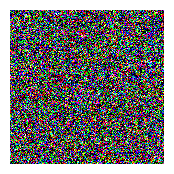

Inference time: 0.1266 seconds
A man is laying on a bench in a park.


In [22]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from torchvision import transforms
from pathlib import Path
from PIL import Image
import numpy as np
import time
import datetime

def imshow(img):
    npimg = img
    plt.figure(figsize=(2, 2))
    plt.imshow(npimg, interpolation='nearest')
    plt.axis('off')
    plt.show()

model.eval()

img, question_placeholder,cls_caption, dec_caption  = stage2_train_dataloader.dataset[5]
img = torch.randn(3,224,224)
img = img.unsqueeze(0)
print(img.shape)
img = img.to(device)

imshow(img[0].cpu().permute(1,2,0).numpy())

input_caption = "Question: describe the image. Answer: "
input_tokens, input_mask = flan_t5_tokenizer.tokenize_text(input_caption)

input_tokens = input_tokens.to(device)
input_mask = input_mask.to(device)

start_time = time.time()
gen_ids = model.forward(img[:1], input_tokens, input_mask, (input_tokens.shape[0], input_tokens.shape[1]))
end_time = time.time()
duration = end_time - start_time
print(f"Inference time: {duration:.4f} seconds")

decoded_output = flan_t5_tokenizer.decode(gen_ids[0])
print(decoded_output)

In [11]:
# Install TensorRT
# !pip install nvidia-pyindex
# !pip install nvidia-tensorrt
# !apt-get update && apt-get install -y python3-pip libboost-all-dev libpython3-dev && rm -rf /var/lib/apt/lists/*
!pip install pycuda

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.3 MB/s  0:00:00 eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=664724 sha256=54fb09a5b438bb3a858c9ea5d721db790e803550ade926766d6904698381434d
  Stored in directory: /home/ubuntu/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pycuda]2m3/4 [pycuda]


In [14]:
import tensorrt as trt
import numpy as np

# Verify TensorRT installation
print("TensorRT version:", trt.__version__)

# Example: Run a TensorRT executable (assuming you have a .trt engine file)
import pycuda.driver as cuda
import pycuda.autoinit

# Load TensorRT engine
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
engine_file_path = "model.trt"  # Replace with your TensorRT engine file path

with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
    engine = runtime.deserialize_cuda_engine(f.read())

# Create execution context
context = engine.create_execution_context()

# Allocate memory for inputs and outputs
input_shape = (1, 3, 224, 224)  # Replace with your model's input shape
output_shape = (1, 1000)  # Replace with your model's output shape
input_data = np.random.random(input_shape).astype(np.float32)
output_data = np.empty(output_shape, dtype=np.float32)

# Allocate device memory
d_input = cuda.mem_alloc(input_data.nbytes)
d_output = cuda.mem_alloc(output_data.nbytes)

# Copy input data to device
cuda.memcpy_htod(d_input, input_data)

# Run inference
bindings = [int(d_input), int(d_output)]
context.execute_v2(bindings)

# Copy output data back to host
cuda.memcpy_dtoh(output_data, d_output)

print("Inference output:", output_data)

TensorRT version: 10.13.2.6


ModuleNotFoundError: No module named 'pycuda'

In [15]:
!pip install --no-cache-dir cuda-python onnx onnxruntime


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 32.7 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [onnxruntime] [onnxruntime]


In [33]:
!pip install --upgrade onnxruntime
import sys
sys.path.append("/home/ubuntu/.local/lib/python3.12/site-packages")
import onnxruntime as ort
print("ORT version:", ort.__version__)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
ORT version: 1.22.1


In [34]:
import os, torch, onnx, onnxruntime as ort, numpy as np

# Silence HF tokenizers parallelism warning (safe)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ----- 1) Prep model & dummy inputs -----
model.cpu().eval()
with torch.no_grad():
    B, C, H, W, S = 1, 3, 224, 224, 77
    img = torch.randn(B, C, H, W, dtype=torch.float32)          # float32
    input_token = torch.zeros(B, S, dtype=torch.long)           # int64
    enc_mask = torch.ones(B, S, dtype=torch.long)               # int64 (or bool)
    dummy_input_size = torch.tensor(S, dtype=torch.int64)       # pass as tensor (safer for dynamo)

    # ----- 2) Export with dynamo path -----
    torch.onnx.export(
        model,
        (img, input_token, enc_mask, dummy_input_size),
        "model.onnx",
        opset_version=18,          # 18 is robust
        dynamo=True,               # new exporter
        export_params=True,
        do_constant_folding=True,
        input_names=["img", "input_token", "enc_mask", "dummy_input_size"],
        output_names=["output"],   # add more names if your model returns multiple tensors
        # NOTE: don't pass dynamic_axes with dynamo=True
    )

# ----- 3) Sanity-check the ONNX -----
onnx.checker.check_model("model.onnx")
print("✔ ONNX model saved & validated as model.onnx")

# ----- 4) Quick ORT inference test -----
sess = ort.InferenceSession("model.onnx")
out = sess.run(
    None,
    {
        "img": np.random.randn(1, 3, 224, 224).astype(np.float32),
        "input_token": np.zeros((1, S), dtype=np.int64),
        "enc_mask": np.ones((1, S), dtype=np.int64),
        "dummy_input_size": np.array(S, dtype=np.int64),  # scalar input to ORT
    },
)
print("ORT outputs:", [np.asarray(o).shape for o in out])

[torch.onnx] Obtain model graph for `Blip2Model([...]` with `torch.export.export(..., strict=False)`...


W0914 13:14:34.902000 1989 torch/fx/experimental/symbolic_shapes.py:7903] Unable to find user code corresponding to {u1}



def forward(self, arg0_1: "f32[1, 1, 192]", arg1_1: "f32[1, 197, 192]", arg2_1: "f32[192, 3, 16, 16]", arg3_1: "f32[192]", arg4_1: "f32[192]", arg5_1: "f32[192]", arg6_1: "f32[576, 192]", arg7_1: "f32[576]", arg8_1: "f32[192, 192]", arg9_1: "f32[192]", arg10_1: "f32[192]", arg11_1: "f32[192]", arg12_1: "f32[768, 192]", arg13_1: "f32[768]", arg14_1: "f32[192, 768]", arg15_1: "f32[192]", arg16_1: "f32[192]", arg17_1: "f32[192]", arg18_1: "f32[576, 192]", arg19_1: "f32[576]", arg20_1: "f32[192, 192]", arg21_1: "f32[192]", arg22_1: "f32[192]", arg23_1: "f32[192]", arg24_1: "f32[768, 192]", arg25_1: "f32[768]", arg26_1: "f32[192, 768]", arg27_1: "f32[192]", arg28_1: "f32[192]", arg29_1: "f32[192]", arg30_1: "f32[576, 192]", arg31_1: "f32[576]", arg32_1: "f32[192, 192]", arg33_1: "f32[192]", arg34_1: "f32[192]", arg35_1: "f32[192]", arg36_1: "f32[768, 192]", arg37_1: "f

[torch.onnx] Obtain model graph for `Blip2Model([...]` with `torch.export.export(..., strict=False)`... ❌
[torch.onnx] Obtain model graph for `Blip2Model([...]` with `torch.export.export(..., strict=True)`...
[torch.onnx] Obtain model graph for `Blip2Model([...]` with `torch.export.export(..., strict=True)`... ❌
[torch.onnx] Obtain model graph for `Blip2Model([...]` with `torch.export draft_export`...


W0914 13:14:40.745000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u1, 1)) -> 0
W0914 13:14:41.817000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u2, 1)) -> 0
W0914 13:14:42.888000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u3, 1)) -> 0
W0914 13:14:43.957000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u4, 1)) -> 0
W0914 13:14:45.020000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u5, 1)) -> 0
W0914 13:14:46.456000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u6, 1)) -> 0
W0914 13:14:47.519000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u7, 1)) -> 0
W0914 13:14:48.595000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(

[torch.onnx] Draft Export report:

###################################################################################################
Please follow the instructions to fix the errors.
###################################################################################################

1. Data dependent error.
    When exporting, we were unable to evaluate the value of `Eq(u1, 1)`.
    This was encountered 30 times.
    This occurred at the following user stacktrace: 
        File /usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py, lineno 2539, in generate
        File /usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py, lineno 2858, in _sample
        File /usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py, lineno 2676, in _has_unfinished_sequences
            elif this_peer_finished:
        
        Locals:
            this_peer_finished: ['Tensor(shape: torch.Size([]), stride: (), storage_offset: 0)']

    And the foll

/usr/local/lib/python3.12/dist-packages/onnx/reference/ops/op_log.py:13: RuntimeWarning: divide by zero encountered in log
  return (np.log(x).astype(x.dtype),)
/usr/local/lib/python3.12/dist-packages/onnx/reference/ops/op_cast.py:149: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype)


Applied 404 of general pattern rewrite rules.


✔ ONNX model saved & validated as model.onnx


Fail: [ONNXRuntimeError] : 1 : FAIL : Load model from model.onnx failed:Node (node_Concat_4464) Op (Concat) [ShapeInferenceError] axis must be in [-rank, rank-1].

In [ ]:
'''
model.train()  - 100.8 ms
model.eval()   - 80.9 ms

'''

In [ ]:

class ExportWrapper(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, img, input_token, enc_mask):
        # derive seq length from tokens to avoid scalar input in the graph
        seq_len = input_token.size(1)
        return self.m(img, input_token, enc_mask, seq_len)

wrapped = ExportWrapper(model).cpu().eval()

with torch.no_grad():
    B, C, H, W, S = 1, 3, 224, 224, 77
    img = torch.randn(B, C, H, W, dtype=torch.float32)
    input_token = torch.zeros(B, S, dtype=torch.long)        # ids int64
    enc_mask = torch.ones(B, S, dtype=torch.long)            # int64 or bool

    # --- re-export with dynamo exporter ---
    torch.onnx.export(
        wrapped,
        (img, input_token, enc_mask),
        "model.onnx",
        opset_version=18,
        dynamo=True,                  # use the new exporter
        export_params=True,
        do_constant_folding=True,
        input_names=["img","input_token","enc_mask"],
        output_names=["output"],      # add more if your model returns multiple
        # (no dynamic_axes with dynamo=True)
    )

onnx.checker.check_model("model.onnx")
print("✔ model.onnx validated")


[torch.onnx] Obtain model graph for `ExportWrapper([...]` with `torch.export.export(..., strict=False)`...


W0914 13:25:47.090000 1989 torch/fx/experimental/symbolic_shapes.py:7903] Unable to find user code corresponding to {u0}



def forward(self, arg0_1: "f32[1, 1, 192]", arg1_1: "f32[1, 197, 192]", arg2_1: "f32[192, 3, 16, 16]", arg3_1: "f32[192]", arg4_1: "f32[192]", arg5_1: "f32[192]", arg6_1: "f32[576, 192]", arg7_1: "f32[576]", arg8_1: "f32[192, 192]", arg9_1: "f32[192]", arg10_1: "f32[192]", arg11_1: "f32[192]", arg12_1: "f32[768, 192]", arg13_1: "f32[768]", arg14_1: "f32[192, 768]", arg15_1: "f32[192]", arg16_1: "f32[192]", arg17_1: "f32[192]", arg18_1: "f32[576, 192]", arg19_1: "f32[576]", arg20_1: "f32[192, 192]", arg21_1: "f32[192]", arg22_1: "f32[192]", arg23_1: "f32[192]", arg24_1: "f32[768, 192]", arg25_1: "f32[768]", arg26_1: "f32[192, 768]", arg27_1: "f32[192]", arg28_1: "f32[192]", arg29_1: "f32[192]", arg30_1: "f32[576, 192]", arg31_1: "f32[576]", arg32_1: "f32[192, 192]", arg33_1: "f32[192]", arg34_1: "f32[192]", arg35_1: "f32[192]", arg36_1: "f32[768, 192]", arg37_1: "f

[torch.onnx] Obtain model graph for `ExportWrapper([...]` with `torch.export.export(..., strict=False)`... ❌
[torch.onnx] Obtain model graph for `ExportWrapper([...]` with `torch.export.export(..., strict=True)`...
[torch.onnx] Obtain model graph for `ExportWrapper([...]` with `torch.export.export(..., strict=True)`... ❌
[torch.onnx] Obtain model graph for `ExportWrapper([...]` with `torch.export draft_export`...


W0914 13:25:52.641000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u0, 1)) -> 0
W0914 13:25:53.788000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u1, 1)) -> 0
W0914 13:25:54.900000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u2, 1)) -> 0
W0914 13:25:56.035000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u3, 1)) -> 0
W0914 13:25:57.139000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u4, 1)) -> 0
W0914 13:25:58.264000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u5, 1)) -> 0
W0914 13:25:59.407000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(Eq(u6, 1)) -> 0
W0914 13:26:00.535000 1989 torch/fx/experimental/symbolic_shapes.py:7242] propagate_real_tensors evaluate_expr(

[torch.onnx] Draft Export report:

###################################################################################################
Please follow the instructions to fix the errors.
###################################################################################################

1. Data dependent error.
    When exporting, we were unable to evaluate the value of `Eq(u0, 1)`.
    This was encountered 30 times.
    This occurred at the following user stacktrace: 
            elif this_peer_finished:
        
        Locals:
            this_peer_finished: ['Tensor(shape: torch.Size([]), stride: (), storage_offset: 0)']

    And the following framework stacktrace: 
            return func(*args, **kwargs)

    As a result, it was specialized to a constant (e.g. `0` in the 1st occurrence), and asserts were inserted into the graph.

    Please add `torch._check(...)` to the original code to assert this data-dependent assumption.
    Please refer to https://docs.google.com/document/d/1

/usr/local/lib/python3.12/dist-packages/onnx/reference/ops/op_log.py:13: RuntimeWarning: divide by zero encountered in log
  return (np.log(x).astype(x.dtype),)
/usr/local/lib/python3.12/dist-packages/onnx/reference/ops/op_cast.py:149: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype)


Applied 404 of general pattern rewrite rules.


✔ model.onnx validated


Fail: [ONNXRuntimeError] : 1 : FAIL : Load model from model.onnx failed:Node (node_Concat_4455) Op (Concat) [ShapeInferenceError] axis must be in [-rank, rank-1].

In [41]:
# pip install onnx onnx_graphsurgeon
import onnx
import onnx_graphsurgeon as gs
import numpy as np
from uuid import uuid4

ONNX_IN  = "model.onnx"
ONNX_OUT = "model_trt.onnx"

def uid(s): return f"{s}_{uuid4().hex[:8]}"

def get_const_int(x):
    if isinstance(x, gs.Constant):
        arr = np.asarray(x.values)
        if arr.size == 1:
            return int(arr.reshape(()).item())
    if isinstance(x, gs.Variable) and x.values is not None:
        arr = np.asarray(x.values)
        if arr.size == 1:
            return int(arr.reshape(()).item())
    return None

model = onnx.load(ONNX_IN)
graph = gs.import_onnx(model)

changed_any = True
while changed_any:
    changed_any = False

    # Collect replacements across the graph in this pass
    tensor_replacements = {}
    nodes_to_remove = []

    for n in list(graph.nodes):
        if n.op != "SplitToSequence":
            continue

        seq_out = n.outputs[0]
        axis = int(n.attrs.get("axis", 0))

        # Find SequenceAt(seq, idx) users
        seqat = []
        for user in list(seq_out.outputs):
            if user.op == "SequenceAt" and len(user.inputs) == 2:
                idx = get_const_int(user.inputs[1])
                if idx is not None and idx >= 0:
                    seqat.append((user, idx))

        if not seqat:
            continue

        # Build Split with enough outputs (0..max idx)
        max_idx = max(idx for _, idx in seqat)
        split_outs = [gs.Variable(name=uid(f"{n.name}_split_{i}")) for i in range(max_idx + 1)]
        split_node = gs.Node(
            op="Split",
            inputs=[n.inputs[0]],
            outputs=split_outs,
            attrs={"axis": axis}
        )
        graph.nodes.append(split_node)

        # For each SequenceAt, create Squeeze and schedule replacement
        for at, idx in seqat:
            src = split_outs[idx]
            out_tensor = at.outputs[0]

            axes_const = gs.Constant(name=uid(f"{at.name}_axes"), values=np.array([axis], dtype=np.int64))
            squeezed = gs.Variable(name=uid(f"{at.name}_squeezed"))
            squeeze_node = gs.Node(op="Squeeze", inputs=[src, axes_const], outputs=[squeezed])
            graph.nodes.append(squeeze_node)

            # Replace all uses of SequenceAt's output with squeezed tensor later
            tensor_replacements[out_tensor] = squeezed
            nodes_to_remove.append(at)

        # Mark the SplitToSequence node for removal
        nodes_to_remove.append(n)
        changed_any = True

    # Apply all tensor replacements at once (prevents partial rewires/cycles)
    if tensor_replacements:
        for node in graph.nodes:
            for i, inp in enumerate(node.inputs):
                if inp in tensor_replacements:
                    node.inputs[i] = tensor_replacements[inp]
        # Also replace in graph outputs if needed
        for i, gout in enumerate(graph.outputs):
            if gout in tensor_replacements:
                graph.outputs[i] = tensor_replacements[gout]

    # Now remove the obsolete nodes
    for n in set(nodes_to_remove):
        if n in graph.nodes:
            graph.nodes.remove(n)

    # Clean between passes
    graph.cleanup().toposort()

# Cast int64 inputs to int32 at the graph boundary
for inp in list(graph.inputs):
    if inp.name in {"input_token", "enc_mask"} and inp.dtype == np.int64:
        cast_out = gs.Variable(name=uid(f"{inp.name}_i32"), dtype=np.int32, shape=inp.shape)
        cast_node = gs.Node(op="Cast", inputs=[inp], outputs=[cast_out],
                            attrs={"to": onnx.TensorProto.INT32})
        graph.nodes.append(cast_node)
        for user in list(inp.outputs):
            user.inputs = [cast_out if x is inp else x for x in user.inputs]

graph.cleanup().toposort()
onnx.save(gs.export_onnx(graph), ONNX_OUT)
print(f"Saved patched ONNX to {ONNX_OUT}")


TypeError: unhashable type: 'Variable'

In [37]:
import numpy as np
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit  # noqa: F401

ONNX_PATH = "model.onnx"
ENGINE_PATH = "model_fp16.engine"

TRT_LOGGER = trt.Logger(trt.Logger.INFO)
print("TensorRT version:", trt.__version__)

# --- 1) Build engine from ONNX ---
def build_engine(onnx_path, fp16=True, workspace_bytes=1<<30):
    builder = trt.Builder(TRT_LOGGER)

    # Create network with EXPLICIT_BATCH
    try:
        flags = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    except AttributeError:
        flags = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    network = builder.create_network(flags)

    parser = trt.OnnxParser(network, TRT_LOGGER)
    with open(onnx_path, "rb") as f:
        ok = parser.parse(f.read())
    if not ok:
        for i in range(parser.num_errors):
            print("Parser error:", parser.get_error(i))
        raise RuntimeError("ONNX parse failed")

    config = builder.create_builder_config()
    # TRT 9+/10 API:
    if hasattr(config, "set_memory_pool_limit"):
        config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, workspace_bytes)
    else:
        config.max_workspace_size = workspace_bytes  # older TRT

    # Enable FP16 if platform supports it
    if fp16 and builder.platform_has_fast_fp16:
        config.set_flag(trt.BuilderFlag.FP16)

    # TRT 9+/10 returns serialized engine bytes
    if hasattr(builder, "build_serialized_network"):
        plan = builder.build_serialized_network(network, config)
        if plan is None:
            raise RuntimeError("Engine build failed")
        runtime = trt.Runtime(TRT_LOGGER)
        engine = runtime.deserialize_cuda_engine(plan)
    else:
        engine = builder.build_engine(network, config)
        if engine is None:
            raise RuntimeError("Engine build failed")

    # Save engine
    with open(ENGINE_PATH, "wb") as f:
        f.write(engine.serialize())
    print(f"Saved engine to {ENGINE_PATH}")
    return engine

# --- 2) Allocate buffers & run one inference ---
def infer(engine):
    context = engine.create_execution_context()

    # Prepare host inputs matching your ONNX (adjust shapes/dtypes!)
    # Example for your model: img [1,3,224,224] float32, token/mask [1,77] int32
    img = np.random.randn(1,3,224,224).astype(np.float32)
    input_token = np.zeros((1,77), dtype=np.int32)   # prefer int32 (see note below)
    enc_mask = np.ones((1,77), dtype=np.int32)

    # Map binding names to host arrays (order must match engine bindings)
    host_inputs_by_name = {
        "img": img,
        "input_token": input_token,
        "enc_mask": enc_mask,
        # If your engine still has "dummy_input_size", remove it at export time as advised earlier
    }

    bindings = [None] * engine.num_bindings
    d_ptrs = [None] * engine.num_bindings
    h_buffers = [None] * engine.num_bindings

    # Set shapes if dynamic (optional, depends on network)
    for idx in range(engine.num_bindings):
        name = engine.get_binding_name(idx)
        is_input = engine.binding_is_input(idx)
        dtype = trt.nptype(engine.get_binding_dtype(idx))
        if is_input:
            host = host_inputs_by_name[name].astype(dtype, copy=False)
            # If network is dynamic, set the shape before allocating
            if hasattr(context, "set_binding_shape"):
                context.set_binding_shape(idx, host.shape)
            size = host.size
        else:
            # Get output shape after shapes are set
            out_shape = tuple(context.get_binding_shape(idx))
            size = int(np.prod(out_shape))
            host = np.empty(size, dtype=dtype)

        dmem = cuda.mem_alloc(host.nbytes)
        d_ptrs[idx] = int(dmem)
        h_buffers[idx] = host
        bindings[idx] = d_ptrs[idx]

    # Copy inputs H2D
    for idx in range(engine.num_bindings):
        if engine.binding_is_input(idx):
            cuda.memcpy_htod(d_ptrs[idx], h_buffers[idx])

    # Execute
    context.execute_v2(bindings)

    # Copy outputs D2H
    outputs = {}
    for idx in range(engine.num_bindings):
        if not engine.binding_is_input(idx):
            name = engine.get_binding_name(idx)
            shape = tuple(context.get_binding_shape(idx))
            host = h_buffers[idx]
            cuda.memcpy_dtoh(host, d_ptrs[idx])
            outputs[name] = host.reshape(shape)
    return outputs

# Build & run
engine = build_engine(ONNX_PATH, fp16=True)
outs = infer(engine)
print("Outputs:")
for k, v in outs.items():
    print(k, v.shape, v.dtype)


TensorRT version: 10.13.2.6
[09/14/2025-13:32:28] [TRT] [W] WARNING The logger passed into createInferBuilder differs from one already registered for an existing builder, runtime, or refitter. So the current new logger is ignored, and TensorRT will use the existing one which is returned by nvinfer1::getLogger() instead.
[09/14/2025-13:32:29] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU -989, GPU +9, now: CPU 19112, GPU 4316 (MiB)
[09/14/2025-13:32:29] [TRT] [I] ----------------------------------------------------------------
[09/14/2025-13:32:29] [TRT] [I] ONNX IR version:  0.0.10
[09/14/2025-13:32:29] [TRT] [I] Opset version:    18
[09/14/2025-13:32:29] [TRT] [I] Producer name:    pytorch
[09/14/2025-13:32:29] [TRT] [I] Producer version: 2.8.0a0+34c6371d24.nv25.08
[09/14/2025-13:32:29] [TRT] [I] Domain:           
[09/14/2025-13:32:29] [TRT] [I] Model version:    0
[09/14/2025-13:32:29] [TRT] [I] Doc string:       
[09/14/2025-13:32:29] [TRT] [I] -----------------------

RuntimeError: ONNX parse failed